In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import os
import sys
import random as rd
import time

sys.path.append("..")
tf.random.set_seed(1234)

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import HenonHeiles_Methods as hh

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

## Load dataset

In [2]:
x, y = hh.read_dataset('x_train_01.txt', 'y_train_01.txt')
train_dataset, val_dataset = hh.train_dataset(x[:300], y[:300], 30, 270, 30) #val_len, train_batch, val_batch

Number of points:  3123


## Define the model:
### a shallow MLP.

In [3]:
#Models
class MyModel1(tf.keras.Model):

    def __init__(self):
        super(MyModel1, self).__init__()
        self.dense1 = tf.keras.layers.Dense(2, activation=tf.nn.tanh)
        
        self.dense2 = tf.keras.layers.Dense(12, activation=tf.nn.tanh)
        self.dense3 = tf.keras.layers.Dense(12, activation=tf.nn.tanh)
        
        self.dense4 = tf.keras.layers.Dense(2, activation=tf.nn.tanh)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)
    
class MyModel2(tf.keras.Model):

    def __init__(self):
        super(MyModel2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(2, activation=tf.nn.tanh)
        
        self.dense2 = tf.keras.layers.Dense(20, activation=tf.nn.tanh)
        self.dense3 = tf.keras.layers.Dense(20, activation=tf.nn.tanh)
        self.dense4 = tf.keras.layers.Dense(20, activation=tf.nn.tanh)
        
        self.dense5 = tf.keras.layers.Dense(2, activation=tf.nn.tanh)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)

        return self.dense5(x)
    

class MyModel3(tf.keras.Model):

    def __init__(self):
        super(MyModel3, self).__init__()
        self.dense1 = tf.keras.layers.Dense(2, activation=tf.nn.tanh)
        
        self.dense2 = tf.keras.layers.Dense(30, activation=tf.nn.tanh)
        self.dense3 = tf.keras.layers.Dense(30, activation=tf.nn.tanh)
        self.dense4 = tf.keras.layers.Dense(30, activation=tf.nn.tanh)
        self.dense5 = tf.keras.layers.Dense(30, activation=tf.nn.tanh)
        
        
        self.densea = tf.keras.layers.Dense(30, activation=tf.nn.tanh)
        self.denseb = tf.keras.layers.Dense(30, activation=tf.nn.tanh)
        self.densec = tf.keras.layers.Dense(30, activation=tf.nn.tanh)


        self.dense6 = tf.keras.layers.Dense(2, activation=tf.nn.tanh)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        
        x = self.densea(x)
        x = self.denseb(x)
        x = self.densec(x)

        return self.dense6(x)
    
model3 = MyModel3()

## Callback function for decaying learning rate

In [4]:
def scheduler(epoch, lr):
    if epoch%100==0:
        print("epoch: ", epoch)
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.0005)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Checkpoints

In [5]:
checkpoint_path_3 = "checkpoints_NN_HH_3/cp.ckpt"
checkpoint_dir_3 = os.path.dirname(checkpoint_path_3)

cp_callback_3 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_3,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=0)

## Training

In [6]:
model3.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["accuracy"],
)

Epochs = 3000
t = time.time()
history3 = model3.fit(train_dataset, epochs = Epochs, validation_data=val_dataset, callbacks=[callback, cp_callback_3], verbose=0)
print("Training time: " + str(time.time()-t))

epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
Training time: 75.9292471408844


## Load best model

In [7]:
model3.load_weights(checkpoint_path_3)

## Plot the loss and save it as a .txt file

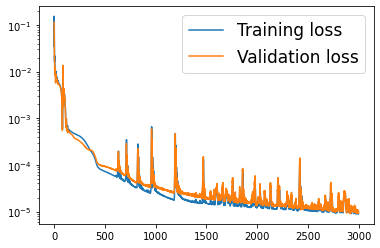

In [8]:
os.remove("NN_Loss.txt")
f = open("NN_Loss.txt", "a")
for i in history3.history["loss"]:
        f.write(str(i))
        f.write("\n")
f.close()

os.remove("NN_Val.txt")
f = open("NN_Val.txt", "a")
for i in history3.history["val_loss"]:
        f.write(str(i))
        f.write("\n")
f.close()

plt.plot(history3.history["loss"], label="Training loss")
plt.plot(history3.history["val_loss"], label="Validation loss")
plt.yscale("log")
plt.legend(fontsize=17)
plt.show()

## Poincare plot

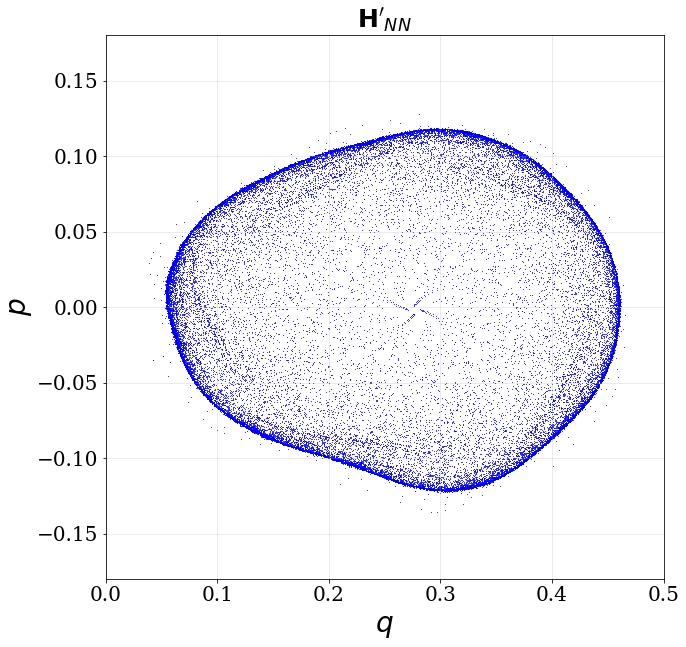

In [9]:
N = 300
x0 = np.array([[rd.randrange(80, 350, 1)*0.001, rd.randrange(-80, 80, 1)*0.001] for _ in range(N)])
iterations = [model3(x0)]
for _ in range(200):
    iterations.append(model3(iterations[-1]))
    
plt.figure(figsize=(10,10))
plt.rc('font', family='serif')
plt.title("$\mathbf{H}'_{NN}$", fontsize = 25)

plt.scatter(*zip(*iterations[0].numpy()), s=1, linewidth=0, color="b", label = "Iterations")

        
for i in iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0, color="b")
    
#plt.scatter(*zip(*x0), s=10, linewidth=0, color="r", label = "Starting points")
plt.xlabel(r'$q$', fontsize=28, labelpad=8)
plt.ylabel(r'$p$', fontsize=28, labelpad=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)

plt.xlim(0., 0.5)
plt.ylim(-0.18, 0.18)

#lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=20)
#lgnd.legendHandles[0]._sizes = [15]
#lgnd.legendHandles[1]._sizes = [30]
plt.savefig("Test_NN_HH")
plt.show()

## Future state prediction

In [11]:
Trajectory_num = 7 # how many trajectories
Trajectory_length = 100 # length of trajectory, same as in the DatasetGenerator file

T = []

read_x = open("trajectory01.txt", "r")
for t in range(Trajectory_num):
    x = []
    for i in range(Trajectory_length):
        x.append([float(read_x.readline()), float(read_x.readline())])
    T.append(x)
read_x.close()

### Starting points from DatasetGenerator

In [13]:
x0 = np.array([[0.1, 0.0],
 [0.35, 0.0],
 [0.17, 0.0],
 [0.3, 0.0],
 [0.4, 0.0],
 [0.33, 0.05],
 [0.33, 0.1]])
    
iterations = [model3(x0)]
for _ in range(Trajectory_length):
    iterations.append(model3(iterations[-1]))

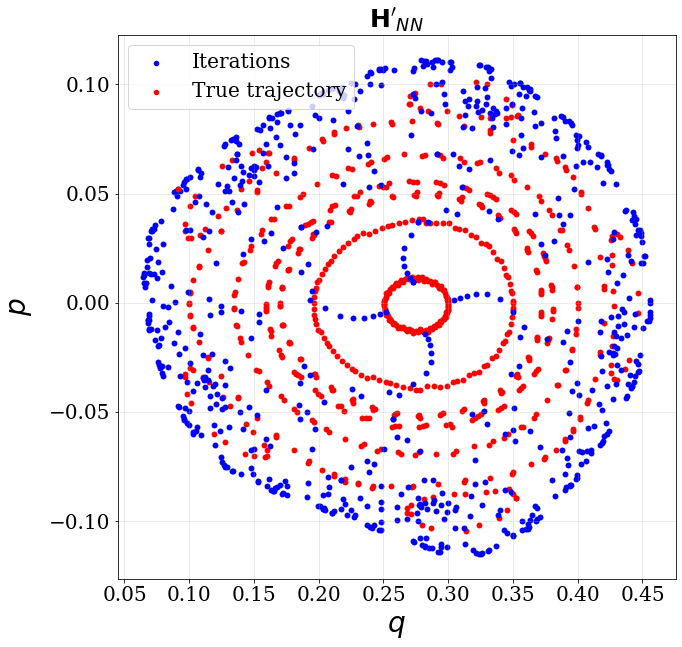

In [14]:
plt.figure(figsize=(10,10))
plt.rc('font', family='serif')
plt.title("$\mathbf{H}'_{NN}$", fontsize = 25)


#plt.scatter(*zip(*x0), s=50, linewidth=0, color="orange", label = "Starting points")

for t in T:
    for i in t:
        plt.scatter(i[0], i[1], s=35, linewidth=0, color="r")



plt.scatter(*zip(*iterations[0].numpy()), s=35, linewidth=0, color="b", label = "Iterations")

for i in iterations:
     plt.scatter(*zip(*i.numpy()), s=35, linewidth=0, color="b")


plt.scatter(i[0][0], i[0][1], s=35, linewidth=0, color="r", label="True trajectory")



plt.xlabel(r'$q$', fontsize=28, labelpad=8)
plt.ylabel(r'$p$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
lgnd = plt.legend(loc="upper left", numpoints=1, fontsize=20)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.savefig("Iteration_Test_NN_HH")
plt.show()